# Homework 3 

You will have 2 datasets to work on. 
#### You have to answer questions in this [form](https://goo.gl/forms/5gfxvKZxpoydoeOB2) and provide your code

### 1. Wikipedia Web Traffic Time Series

Data from [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting)* )

*wikipedia_train3* - train data *wikipedia_test3* - test data created by us from original train data . For more information about dataset, please visit Homework1 assignment

## Wikipedia page views (SMAPE metric)

In [797]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
from dateutil.relativedelta import relativedelta
import math
import seaborn as sns
import matplotlib as plt
import matplotlib.style as style
from IPython.display import Image
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
%matplotlib inline
import calmap
import warnings
import re
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=10,5
warnings.simplefilter('ignore')

In [1016]:
### This is data from wikipedia3 archive in data folder

train = pd.read_csv("../data/wikipedia_train3.csv")
test = pd.read_csv("../data/wikipedia_test3.csv")

In [1037]:
def smape_fast(y_true, y_pred):
    """SMAPE metrics"""
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true.iloc[i]
        b = y_pred[i]
        if b < 1:
            b = 0
        c = a+b
        if c == 0:
            continue
        out += abs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. **For _only_ train** create a holdout validation using any type of split you think is useful here. What is the split type you are using? Answer in google forms

**2.** Write a code to compare the score of your validation and test set. For scoring, use metric SMAPE (code is in lecture). For prediction use 15 previous days median. In the google form write your validation score.

## EDA

In [536]:
start_train = train.date.min()
start_test = test.date.min()
end_train = train.date.max()
end_test = test.date.max()
print(f"Train: {start_train} - {end_train}\nTest: {start_test} - {end_test}")

Train: 2016-01-01 - 2016-08-31
Test: 2016-09-10 - 2016-11-10


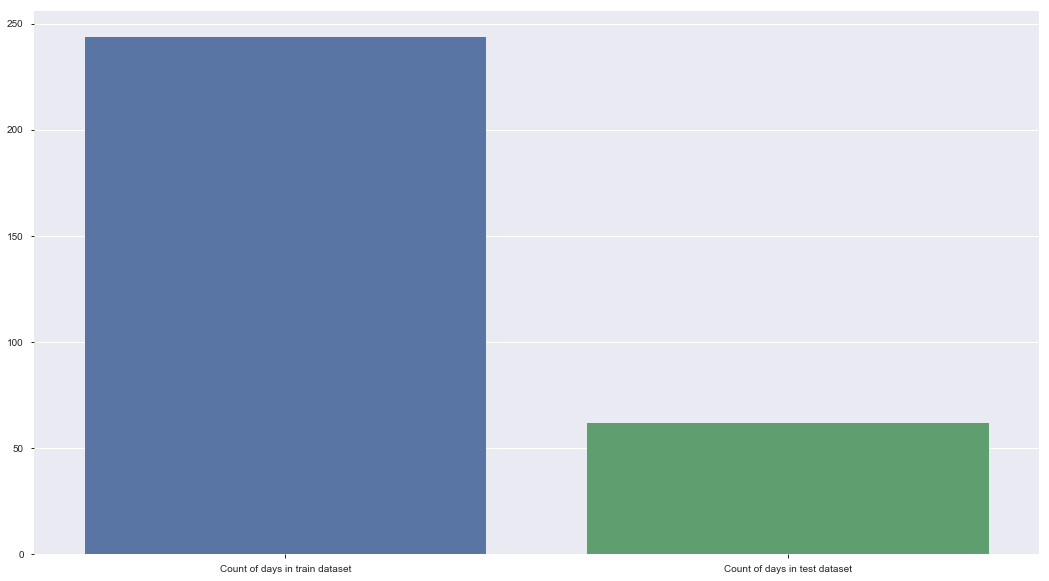

In [537]:
sns.barplot(x=['Count of days in train dataset', 'Count of days in test dataset'],
            y=[train.date.nunique(), test.date.nunique()],
            palette='deep')

In [538]:
# Are there some NaN values?
train.Visits.isnull().sum()

0

In [539]:
# Are there some useless pages?
print(f"Number of unique pages in train: {train.Page.nunique()}\nNumber of unique pages in test: {test.Page.nunique()}")

Number of unique pages in train: 11815
Number of unique pages in test: 11815


## Some preprocess

In [1022]:
#transform date from string to Timestamp
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)

In [1023]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res.group(0)[0:2]
    return 'na'

In [1024]:
def get_access(page):
    return page.split('_')[-2]

In [1025]:
def get_features(df):
    """Add new features to dataframe"""
    
    df['dayofweek'] = df.date.apply(lambda x: x.dayofweek ) 
    df['is_weekend'] = df.date.apply(lambda x: x.dayofweek // 5 )
    df['day'] = df.date.apply(lambda x: x.day)
    df['week'] = df.date.apply(lambda x: x.week)
    
    df['language'] = df.Page.apply(get_language)
    df['access'] = df.Page.apply(get_access)
    
    #Label encoding for page, language, access
    enc = LabelEncoder()
    df.Page = enc.fit_transform(df.Page)
    df.language = enc.fit_transform(df.language)
    df.access = enc.fit_transform(df.access)
    
    
    return df

In [1026]:
# Add new features
train = get_features(train)
test = get_features(test)

## Holdout validation

In [545]:
def create_holdout(df, holdout_size):
    """Function to get indexes of train and holdout for different holdout_size"""
    start = df.date.min()
    finish = df.date.max()
    train_index = df.loc[df.date <= finish - holdout_size].index
    holdout_index = df.loc[df.date > finish - holdout_size].index
    return train_index, holdout_index

In [499]:
def predict_median(train, test, size_of_data_to_predict):
    """Function to predict median of size_of_data_to_predict"""
    median = train[train['date'] > np.max(train['date']) - size_of_data_to_predict].groupby('Page')['Visits'].median().reset_index()
    median.rename(columns={"Visits": "pred_Visits"}, inplace=True)
    return test.merge(median, on='Page', how='left').pred_Visits

### Same days of week 

Train: 2016-01-01 - 2016-07-01
Validation: 2016-07-02 - 2016-08-31 
SMAPE on holdout: 40.73243382113076

SMAPE on test: 40.00701270204617

Difference: 0.7254




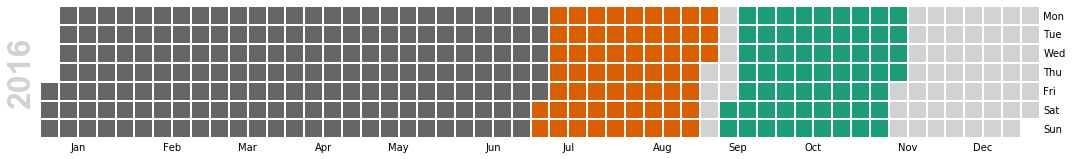

In [510]:
#это лучшее. и стабильное для разных моделей
start_date = pd.Timestamp("2016-07-01")
train_cropped = train.loc[train.date <= test.date.max() - relativedelta(days=71)]
size = relativedelta(train_cropped.date.max(), start_date)
train_i, holdout_i = create_holdout(train_cropped, size)
train_ = train_cropped.loc[train_i]
holdout = train_cropped.loc[holdout_i]
print(f"Train: {train_.date.min().strftime('%Y-%m-%d %H:%M:%S')[:10]} - {train_.date.max().strftime('%Y-%m-%d %H:%M:%S')[:10]}")
print(f"Validation: {holdout.date.min().strftime('%Y-%m-%d %H:%M:%S')[:10]} - {holdout.date.max().strftime('%Y-%m-%d %H:%M:%S')[:10]} ")
total_data = pd.concat([train_.date.value_counts() * 0 , holdout.date.value_counts() * 0.8 , test.date.value_counts()])
fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d2d4', cmap='Dark2_r')
smape_holdout = smape_fast(holdout.Visits, predict_median(train_, holdout, relativedelta(days=15)))
smape_test = smape_fast(test.Visits, predict_median(train, test, relativedelta(days=15)))
print(f"SMAPE on holdout: {smape_holdout}\n\nSMAPE on test: {smape_test}\n\nDifference: {round(abs(smape_holdout - smape_test),4)}\n\n")

Train: 2016-01-01 - 2016-07-08
Validation: 2016-07-09 - 2016-08-31 
SMAPE on holdout: 39.52306683023146

SMAPE on test: 40.00701270204617

Difference: 0.4839




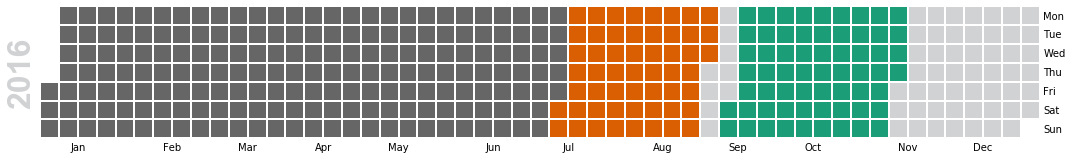

In [511]:
#это тоже неплохое
start_date = pd.Timestamp("2016-07-08")
train_cropped = train.loc[train.date <= test.date.max() - relativedelta(days=71)]
size = relativedelta(train_cropped.date.max(), start_date)
train_i, holdout_i = create_holdout(train_cropped, size)
train_ = train_cropped.loc[train_i]
holdout = train_cropped.loc[holdout_i]
print(f"Train: {train_.date.min().strftime('%Y-%m-%d %H:%M:%S')[:10]} - {train_.date.max().strftime('%Y-%m-%d %H:%M:%S')[:10]}")
print(f"Validation: {holdout.date.min().strftime('%Y-%m-%d %H:%M:%S')[:10]} - {holdout.date.max().strftime('%Y-%m-%d %H:%M:%S')[:10]} ")
total_data = pd.concat([train_.date.value_counts() * 0 , holdout.date.value_counts() * 0.8 , test.date.value_counts()])
fig, ax = calmap.calendarplot(total_data, fig_kws={"figsize":(15,4)}, fillcolor='#d0d2d4', cmap='Dark2_r')
smape_holdout = smape_fast(holdout.Visits, predict_median(train_, holdout, relativedelta(days=15)))
smape_test = smape_fast(test.Visits, predict_median(train, test, relativedelta(days=15)))
print(f"SMAPE on holdout: {smape_holdout}\n\nSMAPE on test: {smape_test}\n\nDifference: {round(abs(smape_holdout - smape_test),4)}\n\n")

### если делать  gap получается фигня. почему?

## KFold validation

**3.** Perform K-fold validation using your type of split. Run GridSearch with any classificator you like and set of parameters to optimize, providing it with your custom validation.  Compare the score of your validation and test set. For scoring, again, use metrics SMAPE. In the google form write your scores on validation and test sets

In [638]:
###time validation
def create_validation_time(df, start_date):
    return df.loc[(df['date'] >= pd.to_datetime(start_date) - relativedelta(days=0)) & \
                  (df['date'] <  pd.to_datetime(start_date) + relativedelta(months=2))].index, \
           df.loc[(df['date'] >= pd.to_datetime(start_date) + relativedelta(months=2)) & \
                  (df['date'] <  pd.to_datetime(start_date) + relativedelta(months=4))].index

In [639]:
### Your validation iterator
train_dates = ['2016-01-01', '2016-02-01',  '2016-03-01', '2016-04-01', '2016-05-01']
CVIterator_time = []
for i in train_dates:
    trainIndices, valIndices = create_validation_time(train, i)
    CVIterator_time.append( (trainIndices, valIndices) )

### Try my TimeValidation on 15 day median

In [640]:
scores = []


for train_ind, holdout_ind in CVIterator_time:
    train_ = train.loc[train_ind]
    holdout = train.loc[holdout_ind]
    print(f"Train: {train_.date.min().strftime('%Y-%m-%d %H:%M:%S')[:10]} - {train_.date.max().strftime('%Y-%m-%d %H:%M:%S')[:10]}")
    print(f"Validation: {holdout.date.min().strftime('%Y-%m-%d %H:%M:%S')[:10]} - {holdout.date.max().strftime('%Y-%m-%d %H:%M:%S')[:10]} ")
    scores.append(smape_fast(train.loc[holdout_ind].Visits,
                             predict_median(train.loc[train_ind], train.loc[holdout_ind], relativedelta(days=15))))
    smape_test = smape_fast(test.Visits, predict_median(train, test, relativedelta(days=15)))
print(f"\n\nCV SMAPE: {np.array(scores).mean()}\nTest SMAPE: {smape_test}\
\nDifference: {round(abs(np.array(scores).mean() - smape_test), 4)}")

Train: 2016-01-01 - 2016-02-29
Validation: 2016-03-01 - 2016-04-30 
Train: 2016-02-01 - 2016-03-31
Validation: 2016-04-01 - 2016-05-31 
Train: 2016-03-01 - 2016-04-30
Validation: 2016-05-01 - 2016-06-30 
Train: 2016-04-01 - 2016-05-31
Validation: 2016-06-01 - 2016-07-31 
Train: 2016-05-01 - 2016-06-30
Validation: 2016-07-01 - 2016-08-31 


CV SMAPE: 41.19977854470543
Test SMAPE: 40.00701270204617
Difference: 1.1928


## Decision Tree Regressor

In [1027]:
def transform(train, test):
    X_train = train.drop(['date', 'Visits'], axis=1)
    X_test = test.drop(['date', 'Visits'], axis=1)
    y_train = train.Visits
    y_test = test.Visits
    return X_train, X_test, y_train, y_test

In [1028]:
X_train, X_test, y_train, y_test = transform(train, test)

In [1029]:
def smape_for_cross_val(estimator, X_test, y_true):
    return smape_fast(y_true, estimator.predict(X_test).round())

In [1045]:
scores = cross_val_score(estimator=DecisionTreeRegressor(random_state=42), cv=CVIterator_time, X=X_train,
                         scoring=smape_for_cross_val, y=y_train)

In [1046]:
smape_test = smape_fast(y_test, DecisionTreeRegressor(random_state=42).fit(X_train, y_train).predict(X_test).round())
print(f"CV SMAPE: {scores.mean()}\nTest SMAPE: {smape_test}\
\nDifference: {round(abs(scores.mean() - smape_test), 4)}")

CV SMAPE: 46.5918372880146
Test SMAPE: 45.1850001088571
Difference: 1.4068


## Grig Search

In [1044]:
params = {'max_depth' : (60,90, None)}
grid = GridSearchCV(estimator=dt, param_grid=params, cv=CVIterator_time, verbose=1,
                    scoring=make_scorer(smape_fast, greater_is_better=False), n_jobs=4)
grid.fit(X_train, y_train)
best_dt = grid.best_estimator_

best_dt.fit(X_train, y_train)
test_smape = smape_fast(y_test, best_dt.predict(X_test))
cv_smape = cross_val_score(estimator=best_dt, cv=CVIterator_time, X=X_train,
                         scoring=smape_for_cross_val, y=y_train).mean()

print(f"CV SMAPE: {cv_smape}\nTest SMAPE: {test_smape}\nDiff: {round(abs(cv_smape - test_smape),4)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  2.3min finished


CV SMAPE: 46.5484690336528
Test SMAPE: 45.13313951336453
Diff: 1.4153


## French house insurance prediction (MAPE metric)

### 2. French dataset

Target variable is prime_tot_ttc – house of insurance price.<p>
The variables in the files are:<p>
code_postal: postal code of the insured property<p>
nb_pieces: number of rooms<p>
veranda: presence of a veranda<p>
biens_nomades: ceiling of coverage of goods (laptop, tablets, musical instruments ,…)<p>
sit_fam: family situation of the insured<p>
profession: profession of the insured<p>
nature_lri: nature of the insured property<p>
societe: company covering the risk<p>
cdomact: area of activity of the insured<p>
niv_urbanisation: level of urbanization in which is the insured property<p>
age_societaire: age of the member<p>
objets_precieux: presence of precious objects in the insured property<p>
pres_contrat_auto: holding a contract of auto insurance<p>
formule: guarantee formula<p>
sit_juridique: legal situation<p>
surf_habitat: area of insured property<p>
patrimoine_mob: amount of heritage insured furniture<p>
var1 - ... - var11: non-explicit variables<p>


**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. You may use any tool you like, any EDA you want. Decribe your validation and reason for your choice in google form.

**2.** 
+ Implement your validation. 
+ Generate additional features. 
+ Build a model you like/you can. 
+ Wait for training your model. If it takes too much time, listen to https://www.youtube.com/watch?v=XWkGL4eZR3E
+ Submit your scores on validation and test to google form. Use MAPE metric for scoring. 
+ Ланфрен ланфра лантатита

In [793]:
import pandas_profiling as pp

In [794]:
def mape(y_true, y_pred):
    """MAPE metrics"""
    return np.sum(100. / y_true.shape[0] * np.abs((y_true - y_pred) / y_true))

In [795]:
def mape_for_cross_val(estimator, x_test, y_true):
    y_pr = estimator.predict(x_test)
    return mape(y_true, y_pr)

In [811]:
train_df = pd.read_csv('../data/train_french.csv')
test_df = pd.read_csv('../data/test_french.csv')

## EDA

In [742]:
pp.ProfileReport(train_df)

Number of variables,29
Number of observations,200000
Total Missing (%),0.0%
Total size in memory,44.3 MiB
Average record size in memory,232.0 B
Numeric,15
Categorical,6
Boolean,8
Date,0
Text (Unique),0
Rejected,0


In [743]:
pp.ProfileReport(test_df)

Number of variables,29
Number of observations,75968
Total Missing (%),0.0%
Total size in memory,16.8 MiB
Average record size in memory,232.0 B
Numeric,15
Categorical,6
Boolean,8
Date,0
Text (Unique),0
Rejected,0


In [744]:
sorted(train_df.profession.unique())==sorted(test_df.profession.unique())

True

In [913]:
train_df.nb_pieces.value_counts()

4    48420
3    47869
1    39152
2    38834
5    25725
Name: nb_pieces, dtype: int64

In [1048]:
test_df.nb_pieces.value_counts(normalize=True)

4    0.207061
3    0.205192
2    0.171993
1    0.171533
6    0.131634
5    0.112587
Name: nb_pieces, dtype: float64

## Preprocess

In [845]:
categorical_features = ['profession', 'sit_fam', 'nature_lri' ]
non_oui_features = ['veranda' , 'var9']

def preprocess(train_, test_):
    train = train_.copy()
    test = test_.copy()
    enc = LabelEncoder()
    all_data = pd.concat([train, test], axis=0)
    for feature in categorical_features:
        enc.fit(all_data[feature])
        train[feature] = enc.transform(train[feature])
        test[feature] = enc.transform(test[feature])
    for feature in non_oui_features:
        train[feature] = train[feature].map({'NON':0, 'OUI':1})
        test[feature] = test[feature].map({'NON':0, 'OUI':1})
    train['niv_urbanisation'] = train['niv_urbanisation'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6, 'G':7, '~':0})
    test['niv_urbanisation'] = test['niv_urbanisation'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6, 'G':7, '~':0})
    xtrain = train.drop(['prime_tot_ttc', 'var4'], axis=1) ##var4 ~ var5
    xtest = test.drop(['prime_tot_ttc', 'var4'], axis=1)
    ytrain = train['prime_tot_ttc']
    ytest = test['prime_tot_ttc']
    return xtrain, xtest, ytrain , ytest

In [846]:
X_train, X_test, y_train, y_test = preprocess(train_df, test_df)

## Validation

In [901]:
print(f"Number of samples in train: {len(train_df)}")
print(f"Number of samples in test: {len(test_df)}")

Number of samples in train: 200000
Number of samples in test: 75968


In [912]:
test_size_percent = len(test_df) / (len(train_df) + len(test_df))
print(f"Percent of test: {test_size}")

Percent of test: 0.275278293135436
Test_size: 55056


In [959]:
###это работает плохо, но это очень "сложные вычисления" и мне жаль удалять

def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]
    
flat_5_indices = train_df.index[train_df.nb_pieces == 5 ].values
flat_no_5_indices = train_df.index[train_df.nb_pieces != 5 ].values

validation_5 = split_list(flat_5_indices, 5)
valid_size = round (len(validation_5[0]) / ( 1 - 0.13) )# with flats!= 5 
train_size = len(train_df) * ( len(train_df[train_df.nb_pieces==5])+ len(test_df)) / ( 5 * len(test_df))
total_size = valid_size + train_size 
percent  = valid_size / (valid_size + train_size)

train_percent = (train_size + valid_size )/ len (flat_no_5_indices )

MY_CV = []
for validation_with_no_5 in validation_5:
    train_m , rest  = train_test_split(train_df.loc[flat_no_5_indices], test_size=train_percent)
    train_s, add_to_valid = train_test_split(train_m, test_size=percent)
    train_indices = train_s.index
    validation_indices = np.append(validation_with_no_5, add_to_valid.index.values)
    MY_CV.append((train_indices, validation_indices))

In [1047]:
##+-
def create_cross_val(X, len_holdout=30000, len_train=130000):
    cv = []
    for nb in range(1,6):
        len_nb = round(len(X[X.nb_pieces==nb]))
        len_nb_in_hold = round(0.1316 * len_holdout) #
        len_not_nb_in_hold = round(0.8784 * len_holdout)
        with_nb = X.index[X.nb_pieces==nb]
        without_nb = X.index[X.nb_pieces != nb]
        valid = with_nb[:len_nb_in_hold]
        valid.append(without_nb[:len_not_nb_in_hold])
        train = without_nb[len_not_nb_in_hold:len_not_nb_in_hold + len_train]
        cv.append((train, valid))
    return cv

cv = create_cross_val(train_df, 37800, 140000)#это чтобы пропорции сохранить

In [1001]:
xgb = XGBRegressor(learning_rate=0.6, max_depth=10, n_estimators=20)
xgb.fit(X_train, y_train)
test_mape = mape(y_test, xgb.predict(X_test))

In [1003]:
cv_mape = cross_val_score(estimator=xgb, cv=cv, X=X_train,
                         scoring=mape_for_cross_val, y=y_train).mean()
print(f"CV MAPE: {cv_mape}\nTest MAPE: {test_mape}\nDiff: {round(abs(cv_mape - test_mape),4)}")

CV MAPE: 9.887113816812889
Test MAPE: 8.799997615055398
Diff: 1.0871


## GridSearch

In [992]:
params = {'max_depth' : (8, 10),
         "n_estimators": (20,100)}
grid = GridSearchCV(estimator=XGBRegressor(random_state=42, learning_rate=0.6), param_grid=params, cv=cv, verbose=1,
                    scoring=make_scorer(mape, greater_is_better=False), n_jobs=4)
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_

best_xgb.fit(X_train, y_train)
test_mape = mape(y_test, best_xgb.predict(X_test))
cv_mape = cross_val_score(estimator=best_xgb, cv=cv, X=X_train,
                         scoring=mape_for_cross_val, y=y_train).mean()

print(f"CV MAPE: {cv_mape}\nTest MAPE: {test_mape}\nDiff: {round(abs(cv_mape - test_mape),4)}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  2.9min finished


CV MAPE: 9.397703913344543
Test MAPE: 8.064639712785379
Diff: 1.3331


## KFold

In [996]:
#не совсем то, что надо, но работает хорошо
#всегда в диапазоне ~0.1-0.2, на любых моделях

In [989]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=42)

params = {'max_depth' : (12, 10),
         "n_estimators": (20,100)}
grid = GridSearchCV(estimator=XGBRegressor(random_state=42, learning_rate=0.6), param_grid=params, cv=kf, verbose=1,
                    scoring=make_scorer(mape, greater_is_better=False), n_jobs=4)
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_

best_xgb.fit(X_train, y_train)
test_mape = mape(y_test, best_xgb.predict(X_test))
cv_mape = cross_val_score(estimator=best_xgb, cv=kf, X=X_train,
                         scoring=mape_for_cross_val, y=y_train).mean()

print(f"CV MAPE: {cv_mape}\nTest MAPE: {test_mape}\nDiff: {round(abs(cv_mape - test_mape),4)}")

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 10.5min finished


CV MAPE: 8.042620794938383
Test MAPE: 8.17427238880933
Diff: 0.1317
